In [1]:
#Import libraries to open data file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from statistics import mean as stat_mean
from numpy import mean
from numpy import std

### One vs all classification: for feature selection

### Normalized Data

#### For AFFF-GW

In [2]:
data_rf = pd.read_csv(r'240617-NTA-Noramlized-Filtered-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [3]:
#Prompt user for source type of interest (AFFF-GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: AFFF-GW


In [4]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [5]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]

#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)
#data_1 = pd.DataFrame(data_1)
#data_1.to_csv('log10_dat.csv', index=False)

In [6]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Logistic Regression
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
C_val = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solver,penalty=penalty,C=C_val)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = LogisticRegression()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.958333 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.998333 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.950000 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.958333 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.941667 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.983333 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.941667 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.925000 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.991667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best: 0.950000 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

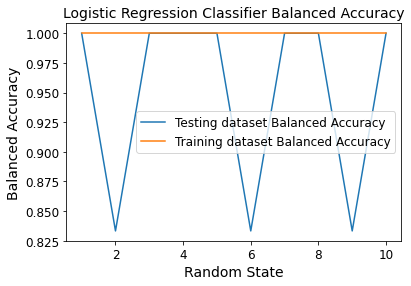

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 1


In [7]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Logistic Regression Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('lR-Tuning-NORM-GW.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [8]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         0.83333333 1.         1.         1.         0.83333333
 1.         1.         0.83333333 1.        ]


Feature: 0, Score: 0.01213
Feature: 1, Score: 0.09116
Feature: 2, Score: 0.37242
Feature: 3, Score: 0.20847
Feature: 4, Score: 0.22717
Feature: 5, Score: -0.00408
Feature: 6, Score: -0.01892
Feature: 7, Score: 0.28259
Feature: 8, Score: -0.00137
Feature: 9, Score: 0.24483
Feature: 10, Score: 0.49664
Feature: 11, Score: 0.29659
Feature: 12, Score: 0.03290
Feature: 13, Score: 0.21606
Feature: 14, Score: 0.30800
Feature: 15, Score: 0.11868
Feature: 16, Score: 0.16981
Feature: 17, Score: 0.03559
Feature: 18, Score: 0.08931
Feature: 19, Score: 0.25602
Feature: 20, Score: 0.00850
Feature: 21, Score: 0.21575
Feature: 22, Score: 0.00012
Feature: 23, Score: 0.16522
Feature: 24, Score: 0.11182
Feature: 25, Score: 0.13073
Feature: 26, Score: 0.41216
Feature: 27, Score: 0.00874
Feature: 28, Score: 0.11467
Feature: 29, Score: 0.00726
Feature: 30, Score: 0.03560
Feature: 31, Score: 0.00604
Feature: 32, Score: -0.08378
Feature: 33, Score: 0.04558
Feature: 34, Score: 0.26128
Feature: 35, Score: 0.1447

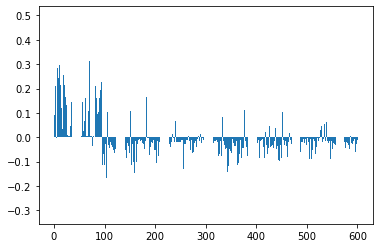

In [9]:
#Now running optimized model over the entire dataset
model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.01213, Standard Deviation: 0.00000
Feature 1: Average Score: 0.09116, Standard Deviation: 0.00000
Feature 2: Average Score: 0.37242, Standard Deviation: 0.00000
Feature 3: Average Score: 0.20847, Standard Deviation: 0.00000
Feature 4: Average Score: 0.22717, Standard Deviation: 0.00000
Feature 5: Average Score: -0.00408, Standard Deviation: 0.00000
Feature 6: Average Score: -0.01892, Standard Deviation: 0.00000
Feature 7: Average Score: 0.28259, Standard Deviation: 0.00000
Feature 8: Average Score: -0.00137, Standard Deviation: 0.00000
Feature 9: Average Score: 0.24483, Standard Deviation: 0.00000
Feature 10: Average Score: 0.49664, Standard Deviation: 0.00000
Feature 11: Average Score: 0.29659, Standard Deviation: 0.00000
Feature 12: Average Score: 0.03290, Standard Deviation: 0.00000
Feature 13: Average Score: 0.21606, Standard Deviation: 0.00000
Feature 14: Average Score: 0.30800, Standard Deviation: 0.00000
Feature 15: Average Score: 0.11868, Standard De

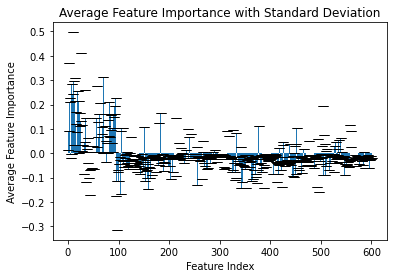

In [10]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.coef_[0]
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [11]:
labels_dat = pd.read_csv("240617-NTA-Noramlized-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 397.951243/11.28, Mean Score: 0.49664, Standard Deviation: 0.00000
Feature: 448.932612/10.45, Mean Score: 0.41216, Standard Deviation: 0.00000
Feature: 398.935583/8.9, Mean Score: 0.37242, Standard Deviation: 0.00000
Feature: 418.997407/8.04, Mean Score: 0.31203, Standard Deviation: 0.00000
Feature: 397.951371/10.99, Mean Score: 0.30800, Standard Deviation: 0.00000
Feature: 143.107393/8.12, Mean Score: 0.29659, Standard Deviation: 0.00000
Feature: 498.929561/11.43, Mean Score: 0.28259, Standard Deviation: 0.00000
Feature: 518.991579/10.48, Mean Score: 0.27418, Standard Deviation: 0.00000
Feature: 339.199094/16.5, Mean Score: 0.26128, Standard Deviation: 0.00000
Feature: 815.904205/9.2, Mean Score: 0.25602, Standard Deviation: 0.00000


In [12]:
labels_dat = pd.read_csv("240617-NTA-Noramlized-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 397.951243/11.28, Mean Score: 0.49664, Standard Deviation: 0.00000
Feature: 448.932612/10.45, Mean Score: 0.41216, Standard Deviation: 0.00000
Feature: 398.935583/8.9, Mean Score: 0.37242, Standard Deviation: 0.00000
Feature: 418.997407/8.04, Mean Score: 0.31203, Standard Deviation: 0.00000
Feature: 397.951371/10.99, Mean Score: 0.30800, Standard Deviation: 0.00000
Feature: 143.107393/8.12, Mean Score: 0.29659, Standard Deviation: 0.00000
Feature: 498.929561/11.43, Mean Score: 0.28259, Standard Deviation: 0.00000
Feature: 518.991579/10.48, Mean Score: 0.27418, Standard Deviation: 0.00000
Feature: 339.199094/16.5, Mean Score: 0.26128, Standard Deviation: 0.00000
Feature: 815.904205/9.2, Mean Score: 0.25602, Standard Deviation: 0.00000


Top Features with Significant Importance:
1. Feature: 397.951243/11.28, Mean Score: 0.49664, Standard Deviation: 0.00000
2. Feature: 448.932612/10.45, Mean Score: 0.41216, Standard Deviation: 0.00000
3. Feature: 398.935583/8.9, Mean Score: 0.37242, Standard Deviation: 0.00000
4. Feature: 418.997407/8.04, Mean Score: 0.31203, Standard Deviation: 0.00000
5. Feature: 397.951371/10.99, Mean Score: 0.30800, Standard Deviation: 0.00000
6. Feature: 143.107393/8.12, Mean Score: 0.29659, Standard Deviation: 0.00000
7. Feature: 498.929561/11.43, Mean Score: 0.28259, Standard Deviation: 0.00000
8. Feature: 518.991579/10.48, Mean Score: 0.27418, Standard Deviation: 0.00000
9. Feature: 339.199094/16.5, Mean Score: 0.26128, Standard Deviation: 0.00000
10. Feature: 815.904205/9.2, Mean Score: 0.25602, Standard Deviation: 0.00000
11. Feature: 298.942577/7.31, Mean Score: 0.24483, Standard Deviation: 0.00000
12. Feature: 348.939226/8.16, Mean Score: 0.22717, Standard Deviation: 0.00000
13. Feature: 313

104. Feature: 373.237559/15.59, Mean Score: 0.01466, Standard Deviation: 0.00000
105. Feature: 498.92902/11.61, Mean Score: 0.01213, Standard Deviation: 0.00000
106. Feature: 187.097628/6.29, Mean Score: 0.01101, Standard Deviation: 0.00000
107. Feature: 348.939634/8, Mean Score: 0.00874, Standard Deviation: 0.00000
108. Feature: 247.961963/7.37, Mean Score: 0.00850, Standard Deviation: 0.00000
109. Feature: 390.964442/9.69, Mean Score: 0.00726, Standard Deviation: 0.00000
110. Feature: 519.956543/10.49, Mean Score: 0.00701, Standard Deviation: 0.00000
111. Feature: 395.243372/18, Mean Score: 0.00663, Standard Deviation: 0.00000
112. Feature: 423.129193/6.26, Mean Score: 0.00643, Standard Deviation: 0.00000
113. Feature: 455.958113/10.25, Mean Score: 0.00640, Standard Deviation: 0.00000
114. Feature: 376.934648/8.54, Mean Score: 0.00636, Standard Deviation: 0.00000
115. Feature: 360.939933/8.25, Mean Score: 0.00630, Standard Deviation: 0.00000
116. Feature: 380.946034/7.56, Mean Score:

216. Feature: 231.137876/11.76, Mean Score: -0.01097, Standard Deviation: 0.00000
217. Feature: 273.116066/8.29, Mean Score: -0.01098, Standard Deviation: 0.00000
218. Feature: 311.131661/8.32, Mean Score: -0.01104, Standard Deviation: 0.00000
219. Feature: 495.186192/6.29, Mean Score: -0.01122, Standard Deviation: 0.00000
220. Feature: 261.113152/6.9, Mean Score: -0.01147, Standard Deviation: 0.00000
221. Feature: 495.280187/6.7, Mean Score: -0.01147, Standard Deviation: 0.00000
222. Feature: 287.129338/9.11, Mean Score: -0.01148, Standard Deviation: 0.00000
223. Feature: 279.917865/6.67, Mean Score: -0.01151, Standard Deviation: 0.00000
224. Feature: 547.470922/17.51, Mean Score: -0.01159, Standard Deviation: 0.00000
225. Feature: 713.389286/10.35, Mean Score: -0.01175, Standard Deviation: 0.00000
226. Feature: 307.190867/12.83, Mean Score: -0.01182, Standard Deviation: 0.00000
227. Feature: 393.227547/8.16, Mean Score: -0.01188, Standard Deviation: 0.00000
228. Feature: 153.09174/7.

343. Feature: 321.242387/15.84, Mean Score: -0.02144, Standard Deviation: 0.00000
344. Feature: 351.220008/15.31, Mean Score: -0.02160, Standard Deviation: 0.00000
345. Feature: 423.202057/6.72, Mean Score: -0.02161, Standard Deviation: 0.00000
346. Feature: 243.195985/13.61, Mean Score: -0.02168, Standard Deviation: 0.00000
347. Feature: 263.074388/8.24, Mean Score: -0.02173, Standard Deviation: 0.00000
348. Feature: 367.229184/16.82, Mean Score: -0.02175, Standard Deviation: 0.00000
349. Feature: 351.216921/11.93, Mean Score: -0.02179, Standard Deviation: 0.00000
350. Feature: 291.160836/9.74, Mean Score: -0.02189, Standard Deviation: 0.00000
351. Feature: 553.357869/9.54, Mean Score: -0.02191, Standard Deviation: 0.00000
352. Feature: 219.983931/6.44, Mean Score: -0.02193, Standard Deviation: 0.00000
353. Feature: 429.223492/10.13, Mean Score: -0.02201, Standard Deviation: 0.00000
354. Feature: 209.094703/7.6, Mean Score: -0.02202, Standard Deviation: 0.00000
355. Feature: 223.11017

474. Feature: 529.279112/8.06, Mean Score: -0.04236, Standard Deviation: 0.00000
475. Feature: 379.176123/6.91, Mean Score: -0.04288, Standard Deviation: 0.00000
476. Feature: 317.211134/11.27, Mean Score: -0.04291, Standard Deviation: 0.00000
477. Feature: 465.404978/19.93, Mean Score: -0.04326, Standard Deviation: 0.00000
478. Feature: 279.123662/7.01, Mean Score: -0.04337, Standard Deviation: 0.00000
479. Feature: 312.96925/14.53, Mean Score: -0.04338, Standard Deviation: 0.00000
480. Feature: 481.331144/15.9, Mean Score: -0.04388, Standard Deviation: 0.00000
481. Feature: 311.185212/8.61, Mean Score: -0.04400, Standard Deviation: 0.00000
482. Feature: 338.091045/7.3, Mean Score: -0.04436, Standard Deviation: 0.00000
483. Feature: 393.212576/6.29, Mean Score: -0.04541, Standard Deviation: 0.00000
484. Feature: 271.064029/6.4, Mean Score: -0.04545, Standard Deviation: 0.00000
485. Feature: 584.280358/19.98, Mean Score: -0.04568, Standard Deviation: 0.00000
486. Feature: 325.147046/9.

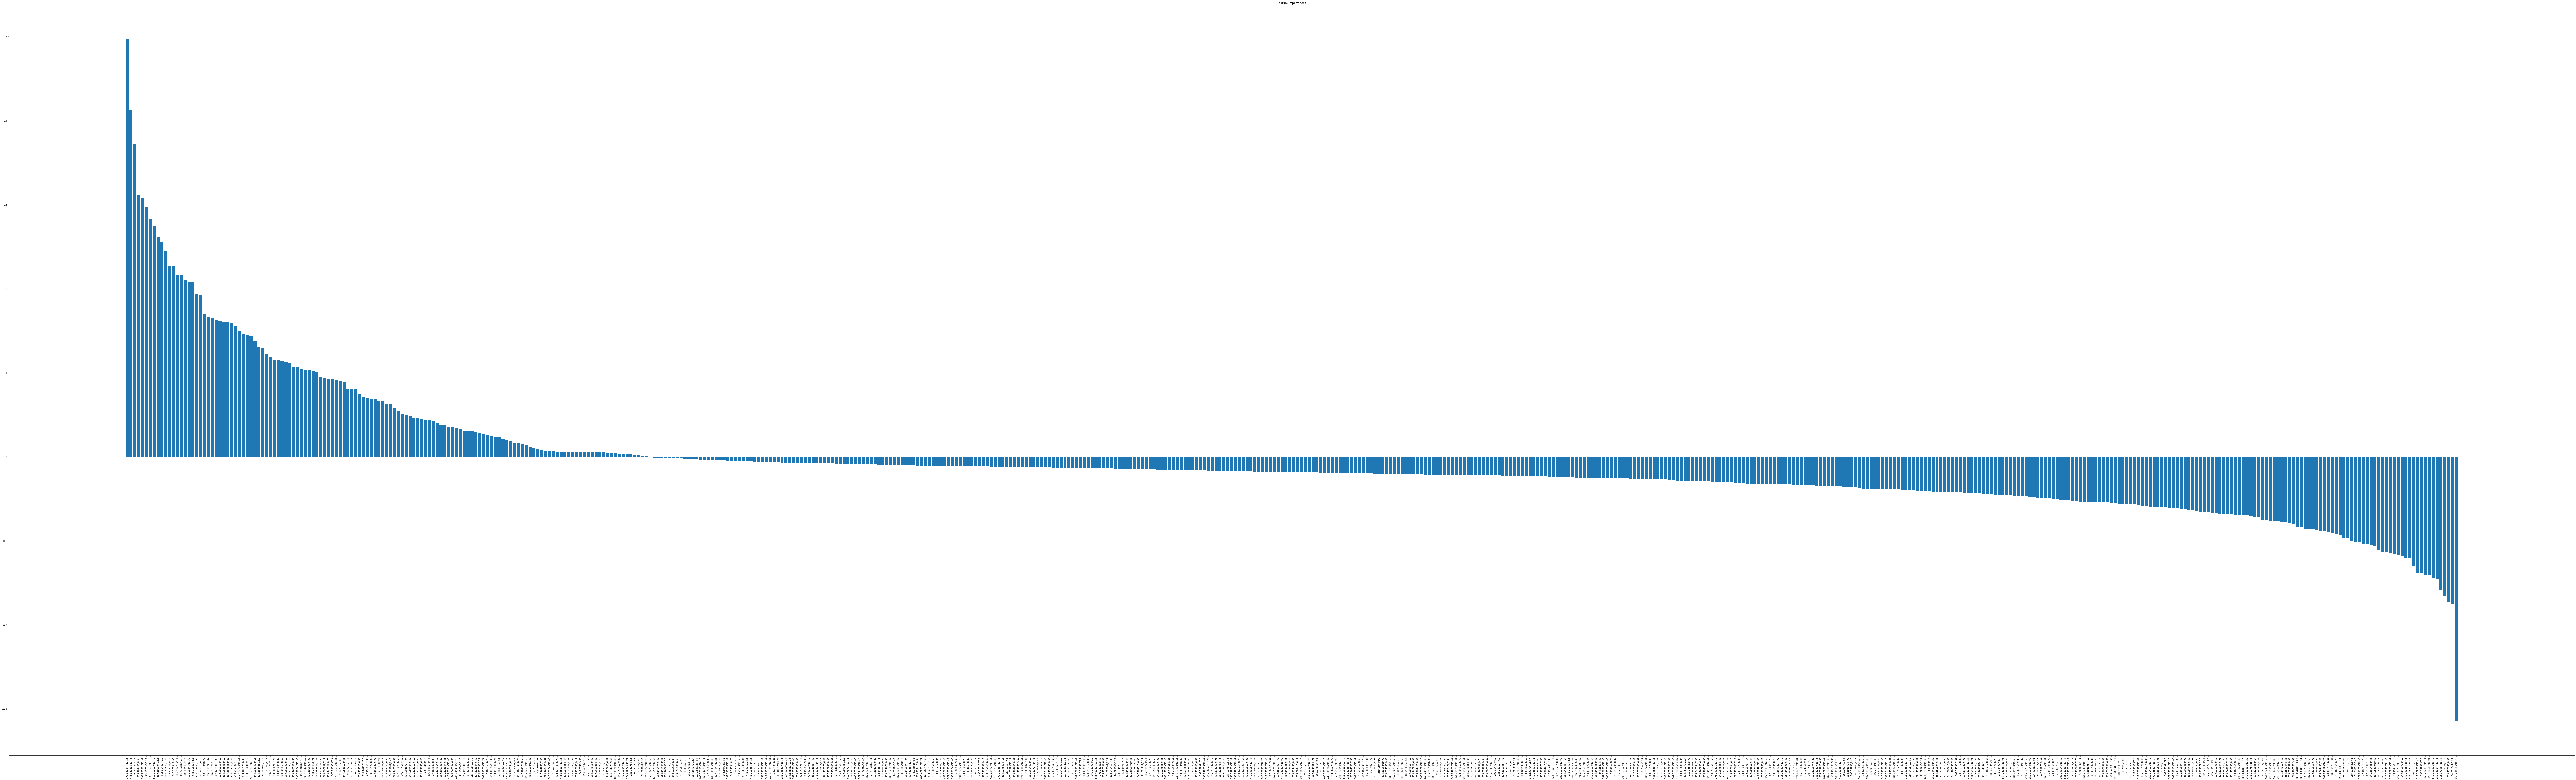

In [13]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_GW.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_GW.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [14]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_norm_GW.xlsx', index=False)

In [15]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [16]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [17]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


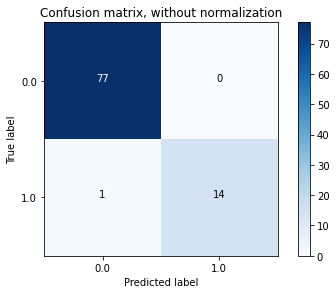

Normalized confusion matrix


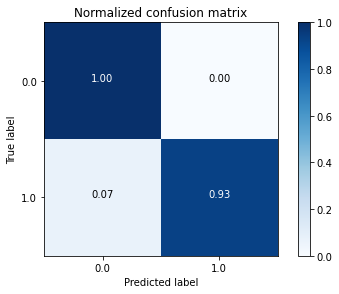

In [18]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

#### For LL

In [19]:
data_rf = pd.read_csv(r'240617-NTA-Noramlized-Filtered-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [20]:
#Prompt user for source type of interest (GW, LL, BL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: LL


In [21]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [22]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [23]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Logistic Regression
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
C_val = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solver,penalty=penalty,C=C_val)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = LogisticRegression()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.960000 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

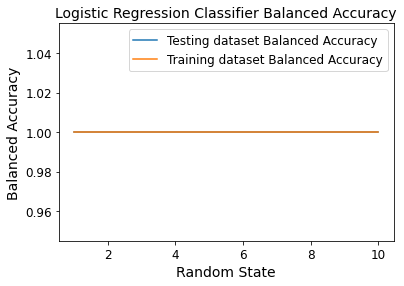

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 1


In [24]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Logistic Regression Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('lR-Tuning-NORM-LL.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [32]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.88 1.   1.   1.   1.   1.   1.   1.   1.   1.  ]


Feature: 0, Score: -0.12519
Feature: 1, Score: -0.02222
Feature: 2, Score: -0.02476
Feature: 3, Score: 0.14078
Feature: 4, Score: -0.06773
Feature: 5, Score: 0.03324
Feature: 6, Score: -0.00679
Feature: 7, Score: -0.11736
Feature: 8, Score: -0.07513
Feature: 9, Score: -0.05248
Feature: 10, Score: -0.11755
Feature: 11, Score: -0.20545
Feature: 12, Score: -0.02236
Feature: 13, Score: 0.16002
Feature: 14, Score: -0.07347
Feature: 15, Score: -0.07118
Feature: 16, Score: -0.01044
Feature: 17, Score: -0.04919
Feature: 18, Score: -0.06273
Feature: 19, Score: -0.04987
Feature: 20, Score: -0.04044
Feature: 21, Score: -0.12582
Feature: 22, Score: -0.04106
Feature: 23, Score: -0.04322
Feature: 24, Score: 0.11205
Feature: 25, Score: -0.05345
Feature: 26, Score: -0.10030
Feature: 27, Score: -0.03958
Feature: 28, Score: 0.14305
Feature: 29, Score: -0.03110
Feature: 30, Score: -0.03629
Feature: 31, Score: -0.02840
Feature: 32, Score: 0.07615
Feature: 33, Score: 0.03632
Feature: 34, Score: -0.13015
Fe

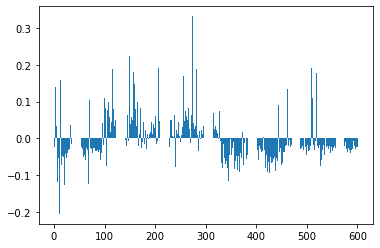

In [25]:
#Now running optimized model over the entire dataset
model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: -0.12519, Standard Deviation: 0.00000
Feature 1: Average Score: -0.02222, Standard Deviation: 0.00000
Feature 2: Average Score: -0.02476, Standard Deviation: 0.00000
Feature 3: Average Score: 0.14078, Standard Deviation: 0.00000
Feature 4: Average Score: -0.06773, Standard Deviation: 0.00000
Feature 5: Average Score: 0.03324, Standard Deviation: 0.00000
Feature 6: Average Score: -0.00679, Standard Deviation: 0.00000
Feature 7: Average Score: -0.11736, Standard Deviation: 0.00000
Feature 8: Average Score: -0.07513, Standard Deviation: 0.00000
Feature 9: Average Score: -0.05248, Standard Deviation: 0.00000
Feature 10: Average Score: -0.11755, Standard Deviation: 0.00000
Feature 11: Average Score: -0.20545, Standard Deviation: 0.00000
Feature 12: Average Score: -0.02236, Standard Deviation: 0.00000
Feature 13: Average Score: 0.16002, Standard Deviation: 0.00000
Feature 14: Average Score: -0.07347, Standard Deviation: 0.00000
Feature 15: Average Score: -0.07118, S

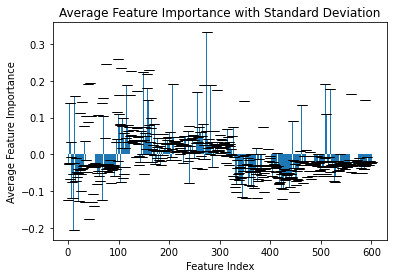

In [26]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.coef_[0]
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [27]:
labels_dat = pd.read_csv("240617-NTA-Noramlized-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 336.994405/6.82, Mean Score: 0.33235, Standard Deviation: 0.00000
Feature: 569.346962/11.86, Mean Score: 0.26017, Standard Deviation: 0.00000
Feature: 227.16461/9.57, Mean Score: 0.24614, Standard Deviation: 0.00000
Feature: 169.122843/8.85, Mean Score: 0.23624, Standard Deviation: 0.00000
Feature: 341.160715/9.2, Mean Score: 0.23080, Standard Deviation: 0.00000
Feature: 167.107402/8.03, Mean Score: 0.22800, Standard Deviation: 0.00000
Feature: 277.144183/7.9, Mean Score: 0.22437, Standard Deviation: 0.00000
Feature: 309.169866/8.17, Mean Score: 0.21788, Standard Deviation: 0.00000
Feature: 309.170052/8.91, Mean Score: 0.19446, Standard Deviation: 0.00000
Feature: 168.989269/6.45, Mean Score: 0.19239, Standard Deviation: 0.00000


In [28]:
labels_dat = pd.read_csv("240617-NTA-Noramlized-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 336.994405/6.82, Mean Score: 0.33235, Standard Deviation: 0.00000
Feature: 569.346962/11.86, Mean Score: 0.26017, Standard Deviation: 0.00000
Feature: 227.16461/9.57, Mean Score: 0.24614, Standard Deviation: 0.00000
Feature: 169.122843/8.85, Mean Score: 0.23624, Standard Deviation: 0.00000
Feature: 341.160715/9.2, Mean Score: 0.23080, Standard Deviation: 0.00000
Feature: 167.107402/8.03, Mean Score: 0.22800, Standard Deviation: 0.00000
Feature: 277.144183/7.9, Mean Score: 0.22437, Standard Deviation: 0.00000
Feature: 309.169866/8.17, Mean Score: 0.21788, Standard Deviation: 0.00000
Feature: 309.170052/8.91, Mean Score: 0.19446, Standard Deviation: 0.00000
Feature: 168.989269/6.45, Mean Score: 0.19239, Standard Deviation: 0.00000


Top Features with Significant Importance:
1. Feature: 336.994405/6.82, Mean Score: 0.33235, Standard Deviation: 0.00000
2. Feature: 569.346962/11.86, Mean Score: 0.26017, Standard Deviation: 0.00000
3. Feature: 227.16461/9.57, Mean Score: 0.24614, Standard Deviation: 0.00000
4. Feature: 169.122843/8.85, Mean Score: 0.23624, Standard Deviation: 0.00000
5. Feature: 341.160715/9.2, Mean Score: 0.23080, Standard Deviation: 0.00000
6. Feature: 167.107402/8.03, Mean Score: 0.22800, Standard Deviation: 0.00000
7. Feature: 277.144183/7.9, Mean Score: 0.22437, Standard Deviation: 0.00000
8. Feature: 309.169866/8.17, Mean Score: 0.21788, Standard Deviation: 0.00000
9. Feature: 309.170052/8.91, Mean Score: 0.19446, Standard Deviation: 0.00000
10. Feature: 168.989269/6.45, Mean Score: 0.19239, Standard Deviation: 0.00000
11. Feature: 333.17028/7.91, Mean Score: 0.19199, Standard Deviation: 0.00000
12. Feature: 603.352759/8.96, Mean Score: 0.19047, Standard Deviation: 0.00000
13. Feature: 233.11819

113. Feature: 206.9982/7.72, Mean Score: 0.03998, Standard Deviation: 0.00000
114. Feature: 227.107349/9.09, Mean Score: 0.03910, Standard Deviation: 0.00000
115. Feature: 325.237814/11.74, Mean Score: 0.03876, Standard Deviation: 0.00000
116. Feature: 441.269924/7.69, Mean Score: 0.03832, Standard Deviation: 0.00000
117. Feature: 317.175476/7.64, Mean Score: 0.03825, Standard Deviation: 0.00000
118. Feature: 351.216921/11.93, Mean Score: 0.03741, Standard Deviation: 0.00000
119. Feature: 495.441089/16.63, Mean Score: 0.03709, Standard Deviation: 0.00000
120. Feature: 246.170568/7.63, Mean Score: 0.03692, Standard Deviation: 0.00000
121. Feature: 212.979052/6.43, Mean Score: 0.03632, Standard Deviation: 0.00000
122. Feature: 335.221766/9.05, Mean Score: 0.03629, Standard Deviation: 0.00000
123. Feature: 377.217372/6.9, Mean Score: 0.03602, Standard Deviation: 0.00000
124. Feature: 519.33485/10.11, Mean Score: 0.03509, Standard Deviation: 0.00000
125. Feature: 237.125873/8.73, Mean Scor

251. Feature: 425.274845/9.11, Mean Score: -0.00834, Standard Deviation: 0.00000
252. Feature: 249.11298/6.85, Mean Score: -0.00864, Standard Deviation: 0.00000
253. Feature: 335.221889/10.08, Mean Score: -0.00876, Standard Deviation: 0.00000
254. Feature: 311.131661/8.32, Mean Score: -0.00903, Standard Deviation: 0.00000
255. Feature: 199.075894/9.5, Mean Score: -0.00913, Standard Deviation: 0.00000
256. Feature: 201.113334/6.68, Mean Score: -0.00964, Standard Deviation: 0.00000
257. Feature: 445.36688/15.51, Mean Score: -0.00987, Standard Deviation: 0.00000
258. Feature: 279.159703/7.76, Mean Score: -0.00992, Standard Deviation: 0.00000
259. Feature: 368.97633/10.22, Mean Score: -0.01044, Standard Deviation: 0.00000
260. Feature: 529.279112/8.06, Mean Score: -0.01048, Standard Deviation: 0.00000
261. Feature: 309.205869/8.62, Mean Score: -0.01213, Standard Deviation: 0.00000
262. Feature: 291.19578/12.22, Mean Score: -0.01256, Standard Deviation: 0.00000
263. Feature: 247.097464/6.67

373. Feature: 415.21278/8.34, Mean Score: -0.02847, Standard Deviation: 0.00000
374. Feature: 448.210221/10, Mean Score: -0.02864, Standard Deviation: 0.00000
375. Feature: 543.388957/16.75, Mean Score: -0.02868, Standard Deviation: 0.00000
376. Feature: 281.210666/12.37, Mean Score: -0.02884, Standard Deviation: 0.00000
377. Feature: 283.226348/15.43, Mean Score: -0.02885, Standard Deviation: 0.00000
378. Feature: 541.517185/21.43, Mean Score: -0.02910, Standard Deviation: 0.00000
379. Feature: 431.206799/6.96, Mean Score: -0.02932, Standard Deviation: 0.00000
380. Feature: 371.243362/11.25, Mean Score: -0.02934, Standard Deviation: 0.00000
381. Feature: 324.97712/7.14, Mean Score: -0.02939, Standard Deviation: 0.00000
382. Feature: 383.351339/20.58, Mean Score: -0.02940, Standard Deviation: 0.00000
383. Feature: 402.204504/10.13, Mean Score: -0.02961, Standard Deviation: 0.00000
384. Feature: 241.180143/12.13, Mean Score: -0.02973, Standard Deviation: 0.00000
385. Feature: 445.293613

479. Feature: 588.427608/20.23, Mean Score: -0.04546, Standard Deviation: 0.00000
480. Feature: 551.502495/18.59, Mean Score: -0.04570, Standard Deviation: 0.00000
481. Feature: 477.212079/6.55, Mean Score: -0.04581, Standard Deviation: 0.00000
482. Feature: 363.108754/6.23, Mean Score: -0.04586, Standard Deviation: 0.00000
483. Feature: 604.459177/20.4, Mean Score: -0.04603, Standard Deviation: 0.00000
484. Feature: 361.202243/9.92, Mean Score: -0.04609, Standard Deviation: 0.00000
485. Feature: 285.206165/9.83, Mean Score: -0.04632, Standard Deviation: 0.00000
486. Feature: 391.139756/6.49, Mean Score: -0.04649, Standard Deviation: 0.00000
487. Feature: 201.149091/8.8, Mean Score: -0.04663, Standard Deviation: 0.00000
488. Feature: 191.107759/7.5, Mean Score: -0.04679, Standard Deviation: 0.00000
489. Feature: 460.933583/10.29, Mean Score: -0.04716, Standard Deviation: 0.00000
490. Feature: 229.143226/8.73, Mean Score: -0.04735, Standard Deviation: 0.00000
491. Feature: 367.212948/10

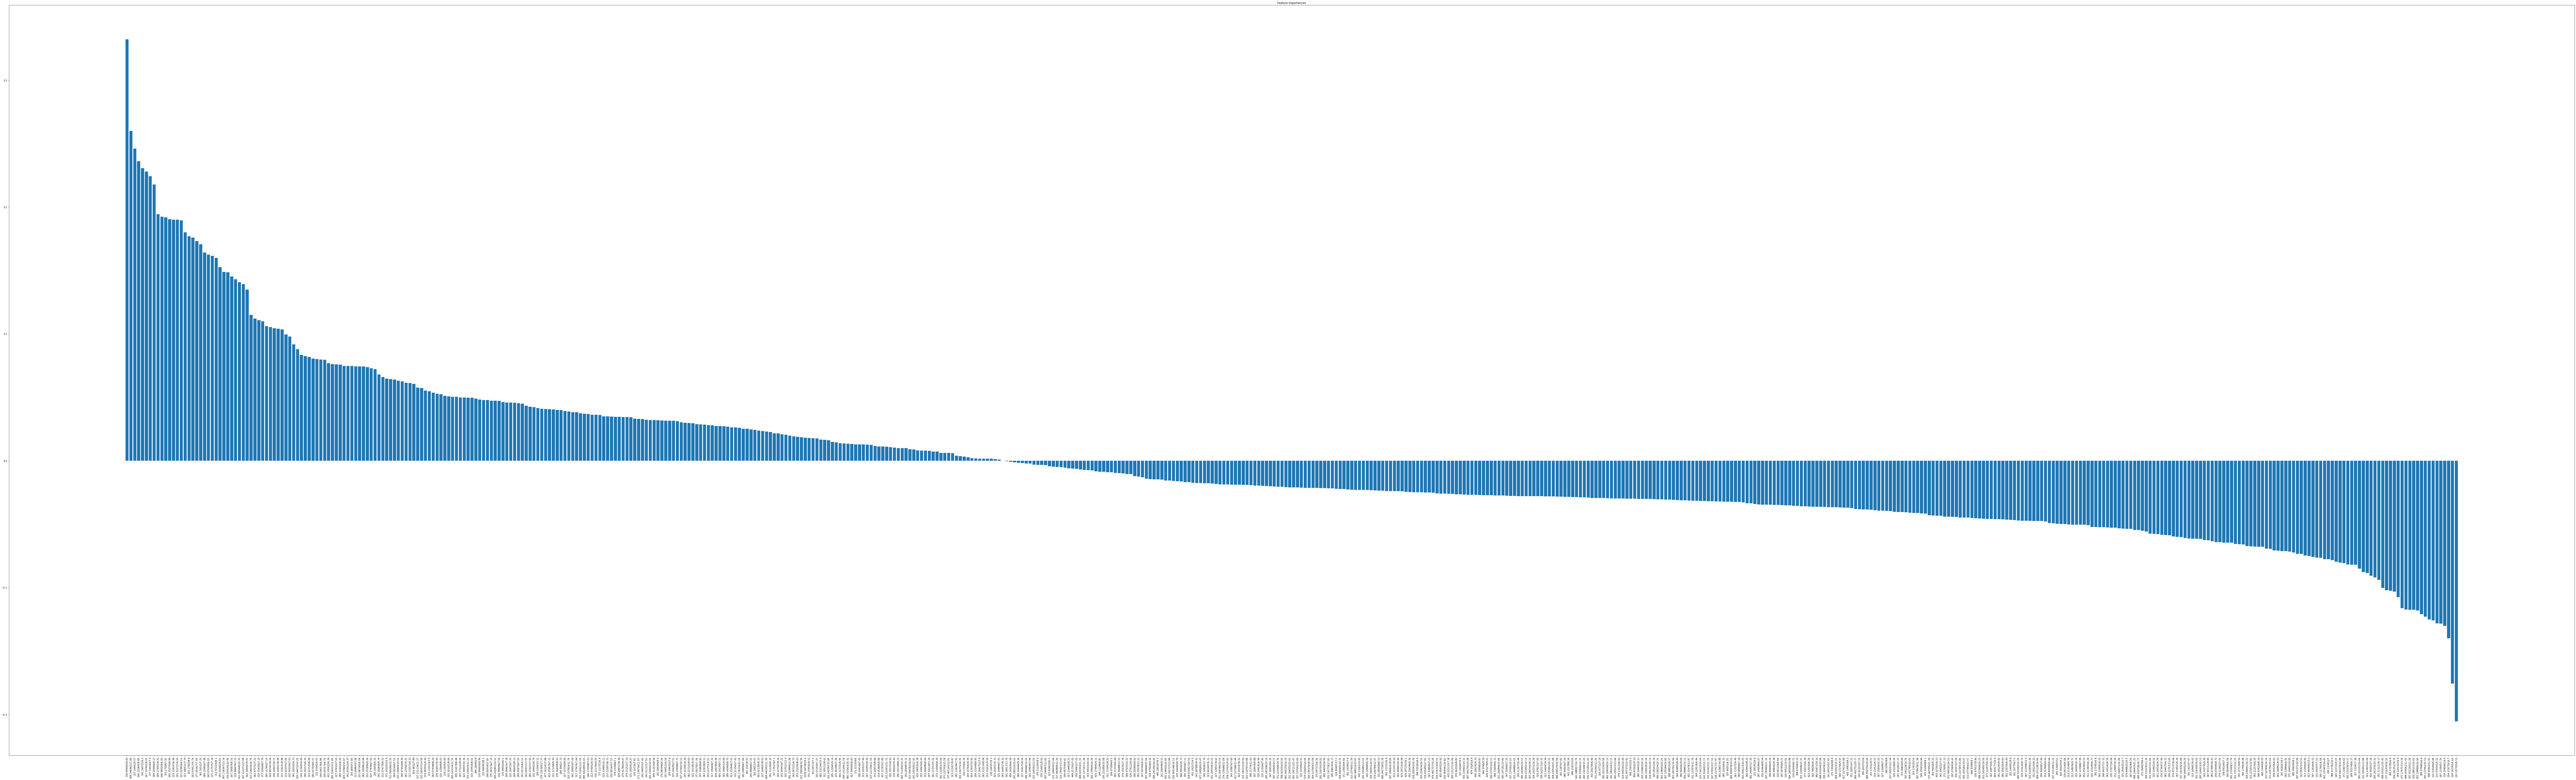

In [29]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_LL.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_LL.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [30]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_norm_LL.xlsx', index=False)

In [31]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [32]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [33]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


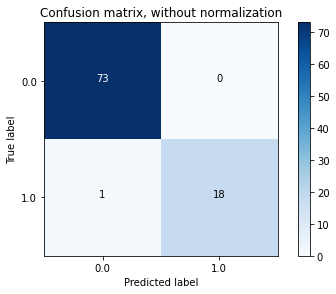

Normalized confusion matrix


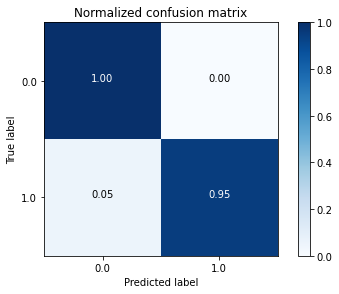

In [34]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### For BL

In [35]:
data_rf = pd.read_csv(r'240617-NTA-Noramlized-Filtered-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [36]:
#Prompt user for source type of interest (GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: BL


In [37]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [38]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [39]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Logistic Regression
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
C_val = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solver,penalty=penalty,C=C_val)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create lr classifier
    rf = LogisticRegression()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.958333 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.958333 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.958333 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 1.000000 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.915000 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.950000 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.941667 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.991667 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.958333 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best: 1.000000 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

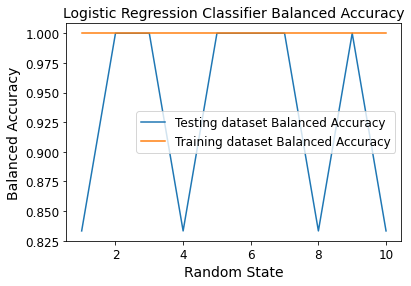

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 2


In [40]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Logistic Regression Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('lR-Tuning-NORM-BL.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [41]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.83 1.   1.   0.83 1.   1.   1.   0.83 1.   0.83]


Feature: 0, Score: 0.35237
Feature: 1, Score: -0.15003
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.01877
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.13967
Feature: 9, Score: -0.13320
Feature: 10, Score: -0.08570
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.03283
Feature: 14, Score: -0.18385
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: -0.34817
Feature: 20, Score: 0.00000
Feature: 21, Score: -0.24434
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.10698
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00

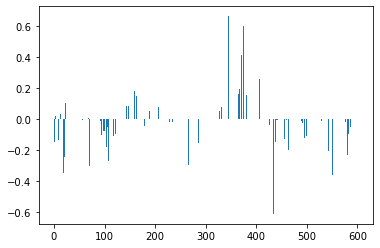

In [42]:
#Now running optimized model over the entire dataset
model = LogisticRegression(solver = 'liblinear', C = 100, penalty = 'l1')
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.37774, Standard Deviation: 0.06163
Feature 1: Average Score: -0.04749, Standard Deviation: 0.05163
Feature 2: Average Score: -0.00161, Standard Deviation: 0.00586
Feature 3: Average Score: 0.00995, Standard Deviation: 0.01649
Feature 4: Average Score: -0.00085, Standard Deviation: 0.00843
Feature 5: Average Score: 0.00088, Standard Deviation: 0.00534
Feature 6: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 7: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 8: Average Score: 0.16871, Standard Deviation: 0.05043
Feature 9: Average Score: -0.07285, Standard Deviation: 0.04921
Feature 10: Average Score: -0.15943, Standard Deviation: 0.05985
Feature 11: Average Score: -0.00123, Standard Deviation: 0.01777
Feature 12: Average Score: -0.00084, Standard Deviation: 0.00322
Feature 13: Average Score: 0.09952, Standard Deviation: 0.02989
Feature 14: Average Score: -0.19381, Standard Deviation: 0.07773
Feature 15: Average Score: -0.00959, Stand

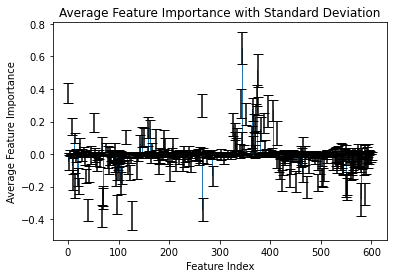

In [43]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = LogisticRegression(solver = 'liblinear', C = 100, penalty = 'l1')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.coef_[0]
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [44]:
labels_dat = pd.read_csv("240617-NTA-Noramlized-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 277.179757/13.18, Mean Score: 0.65223, Standard Deviation: 0.09632
Feature: 312.96925/14.53, Mean Score: 0.51476, Standard Deviation: 0.09995
Feature: 498.92902/11.61, Mean Score: 0.37774, Standard Deviation: 0.06163
Feature: 653.298896/16.66, Mean Score: 0.36005, Standard Deviation: 0.06644
Feature: 301.215668/17.74, Mean Score: 0.31086, Standard Deviation: 0.08863
Feature: 397.25809/10.52, Mean Score: 0.29622, Standard Deviation: 0.07055
Feature: 353.231311/12.25, Mean Score: 0.29396, Standard Deviation: 0.05521
Feature: 367.212948/10.5, Mean Score: 0.27520, Standard Deviation: 0.07173
Feature: 307.189978/9.88, Mean Score: 0.26865, Standard Deviation: 0.06313
Feature: 372.990181/14.53, Mean Score: 0.26496, Standard Deviation: 0.10099


In [45]:
labels_dat = pd.read_csv("240617-NTA-Noramlized-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 277.179757/13.18, Mean Score: 0.65223, Standard Deviation: 0.09632
Feature: 312.96925/14.53, Mean Score: 0.51476, Standard Deviation: 0.09995
Feature: 498.92902/11.61, Mean Score: 0.37774, Standard Deviation: 0.06163
Feature: 653.298896/16.66, Mean Score: 0.36005, Standard Deviation: 0.06644
Feature: 301.215668/17.74, Mean Score: 0.31086, Standard Deviation: 0.08863
Feature: 397.25809/10.52, Mean Score: 0.29622, Standard Deviation: 0.07055
Feature: 353.231311/12.25, Mean Score: 0.29396, Standard Deviation: 0.05521
Feature: 367.212948/10.5, Mean Score: 0.27520, Standard Deviation: 0.07173
Feature: 307.189978/9.88, Mean Score: 0.26865, Standard Deviation: 0.06313
Feature: 372.990181/14.53, Mean Score: 0.26496, Standard Deviation: 0.10099


Top Features with Significant Importance:
1. Feature: 277.179757/13.18, Mean Score: 0.65223, Standard Deviation: 0.09632
2. Feature: 312.96925/14.53, Mean Score: 0.51476, Standard Deviation: 0.09995
3. Feature: 498.92902/11.61, Mean Score: 0.37774, Standard Deviation: 0.06163
4. Feature: 653.298896/16.66, Mean Score: 0.36005, Standard Deviation: 0.06644
5. Feature: 301.215668/17.74, Mean Score: 0.31086, Standard Deviation: 0.08863
6. Feature: 397.25809/10.52, Mean Score: 0.29622, Standard Deviation: 0.07055
7. Feature: 353.231311/12.25, Mean Score: 0.29396, Standard Deviation: 0.05521
8. Feature: 367.212948/10.5, Mean Score: 0.27520, Standard Deviation: 0.07173
9. Feature: 307.189978/9.88, Mean Score: 0.26865, Standard Deviation: 0.06313
10. Feature: 372.990181/14.53, Mean Score: 0.26496, Standard Deviation: 0.10099
11. Feature: 326.186517/16.01, Mean Score: 0.24780, Standard Deviation: 0.06743
12. Feature: 495.439738/16.77, Mean Score: 0.22538, Standard Deviation: 0.08273
13. Feature:

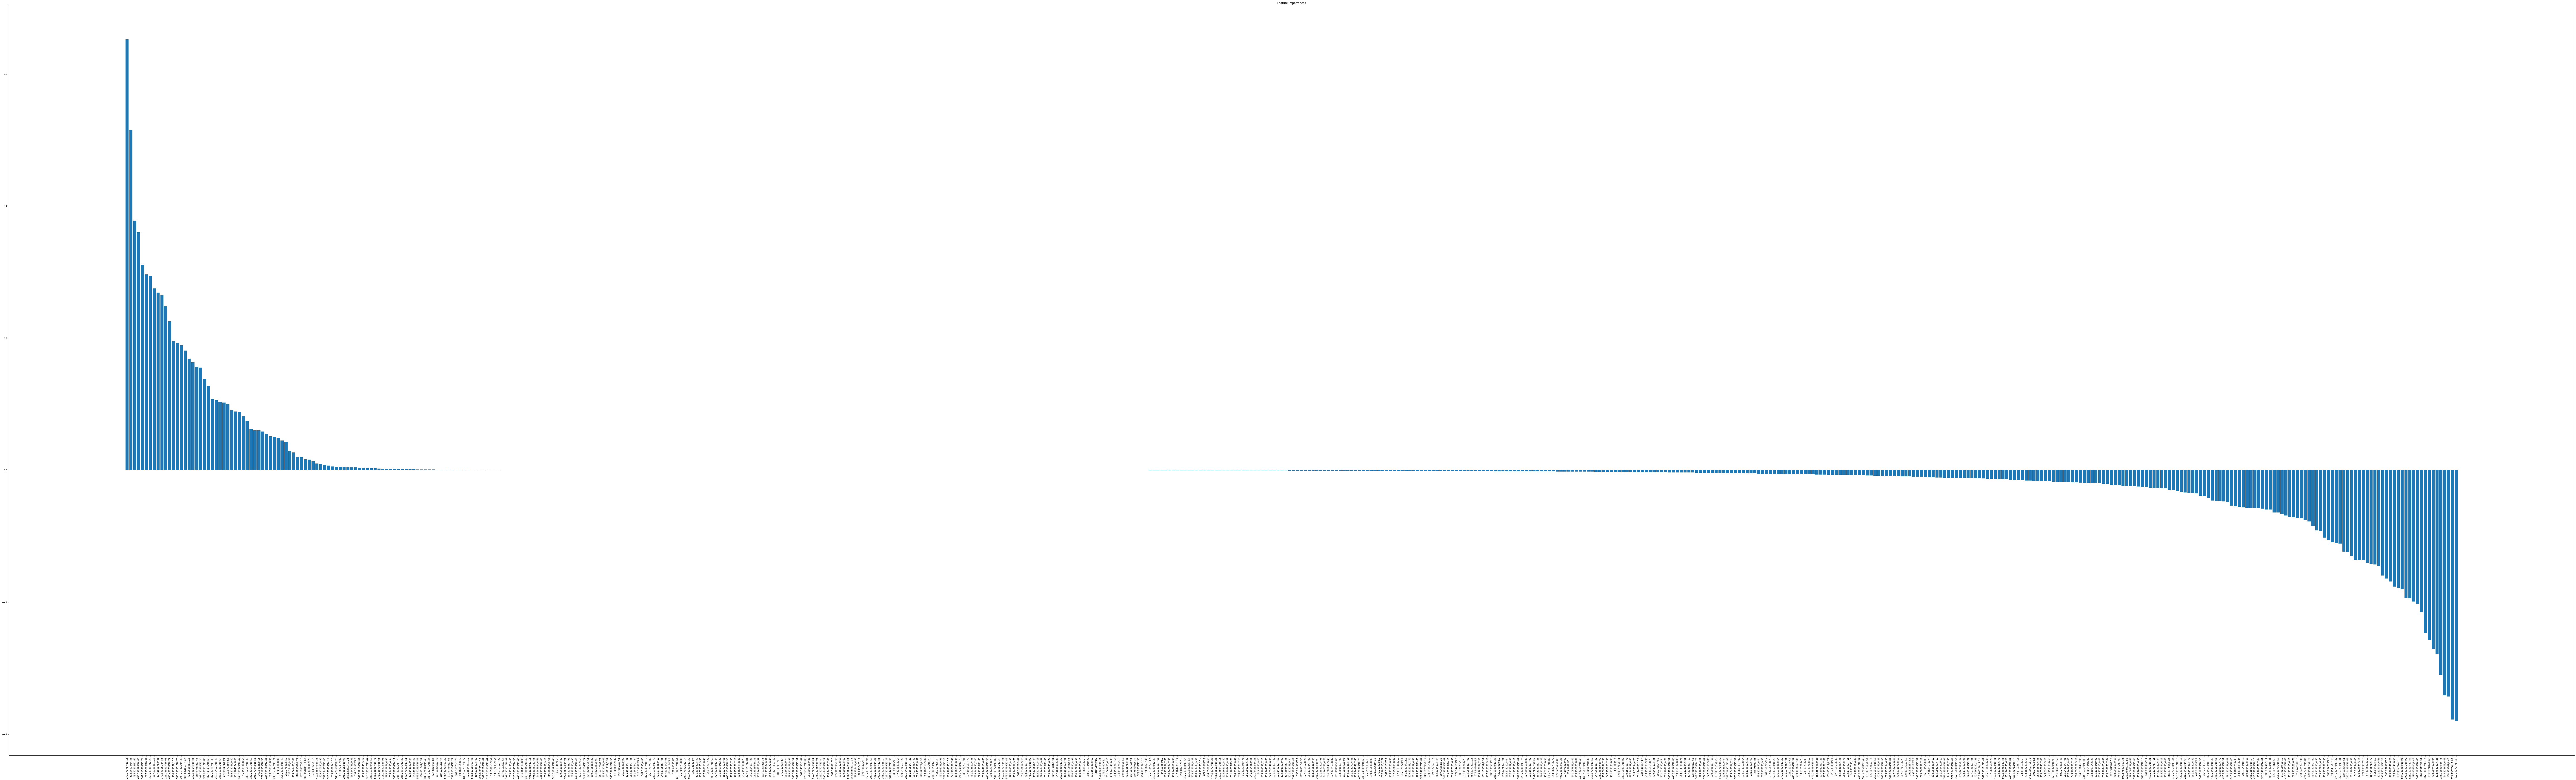

In [46]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_BL.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_BL.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [47]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_BL.xlsx', index=False)

In [48]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = LogisticRegression(solver = 'liblinear', C = 100, penalty = 'l1')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [49]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [50]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


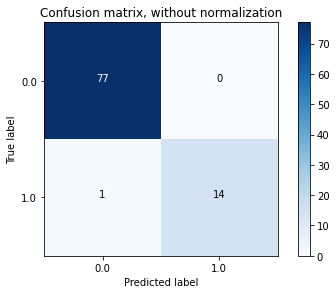

Normalized confusion matrix


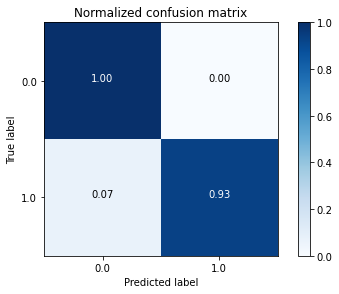

In [51]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### WWTP

In [52]:
data_rf = pd.read_csv(r'240617-NTA-Noramlized-Filtered-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [53]:
#Prompt user for source type of interest (GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: WWTP


In [54]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [55]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [56]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Logistic Regression
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
C_val = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solver,penalty=penalty,C=C_val)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = LogisticRegression()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.946667 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 1.000000 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.958246 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.973333 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.986667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.973333 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.973333 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.973333 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Best: 0.966667 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

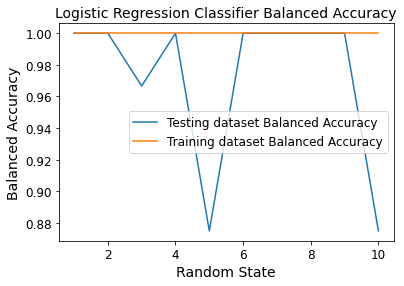

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 1


In [57]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Logistic Regression Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('lR-Tuning-NORM-WWTP.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [58]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.   1.   0.97 1.   0.88 1.   1.   1.   1.   0.88]


Feature: 0, Score: -0.09601
Feature: 1, Score: -0.05054
Feature: 2, Score: -0.22955
Feature: 3, Score: -0.17362
Feature: 4, Score: -0.09151
Feature: 5, Score: -0.16069
Feature: 6, Score: -0.01856
Feature: 7, Score: -0.10961
Feature: 8, Score: -0.27396
Feature: 9, Score: -0.10851
Feature: 10, Score: -0.21644
Feature: 11, Score: -0.25273
Feature: 12, Score: -0.14927
Feature: 13, Score: -0.23469
Feature: 14, Score: -0.12741
Feature: 15, Score: -0.01842
Feature: 16, Score: -0.10580
Feature: 17, Score: -0.00909
Feature: 18, Score: -0.00602
Feature: 19, Score: -0.13141
Feature: 20, Score: 0.00934
Feature: 21, Score: 0.07590
Feature: 22, Score: 0.00947
Feature: 23, Score: -0.14120
Feature: 24, Score: -0.15755
Feature: 25, Score: -0.16049
Feature: 26, Score: -0.20374
Feature: 27, Score: 0.00943
Feature: 28, Score: -0.09996
Feature: 29, Score: 0.01010
Feature: 30, Score: 0.00485
Feature: 31, Score: 0.01097
Feature: 32, Score: -0.12424
Feature: 33, Score: -0.02725
Feature: 34, Score: -0.07084
Fe

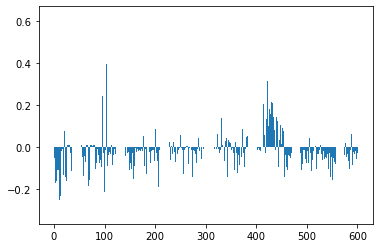

In [59]:
#Now running optimized model over the entire dataset
model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: -0.09601, Standard Deviation: 0.00000
Feature 1: Average Score: -0.05054, Standard Deviation: 0.00000
Feature 2: Average Score: -0.22955, Standard Deviation: 0.00000
Feature 3: Average Score: -0.17362, Standard Deviation: 0.00000
Feature 4: Average Score: -0.09151, Standard Deviation: 0.00000
Feature 5: Average Score: -0.16069, Standard Deviation: 0.00000
Feature 6: Average Score: -0.01856, Standard Deviation: 0.00000
Feature 7: Average Score: -0.10961, Standard Deviation: 0.00000
Feature 8: Average Score: -0.27396, Standard Deviation: 0.00000
Feature 9: Average Score: -0.10851, Standard Deviation: 0.00000
Feature 10: Average Score: -0.21644, Standard Deviation: 0.00000
Feature 11: Average Score: -0.25273, Standard Deviation: 0.00000
Feature 12: Average Score: -0.14927, Standard Deviation: 0.00000
Feature 13: Average Score: -0.23469, Standard Deviation: 0.00000
Feature 14: Average Score: -0.12741, Standard Deviation: 0.00000
Feature 15: Average Score: -0.01842

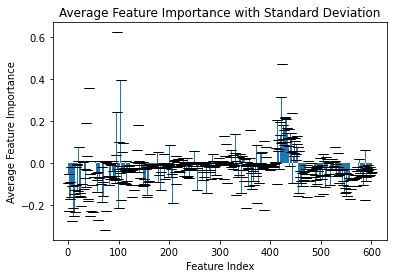

In [60]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.coef_[0]
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [61]:
labels_dat = pd.read_csv("240617-NTA-Noramlized-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 253.216616/16.76, Mean Score: 0.62225, Standard Deviation: 0.00000
Feature: 285.079865/6.6, Mean Score: 0.47191, Standard Deviation: 0.00000
Feature: 132.056597/7.15, Mean Score: 0.39530, Standard Deviation: 0.00000
Feature: 159.102365/6.61, Mean Score: 0.35704, Standard Deviation: 0.00000
Feature: 410.042053/7.26, Mean Score: 0.31413, Standard Deviation: 0.00000
Feature: 279.232289/17.37, Mean Score: 0.24319, Standard Deviation: 0.00000
Feature: 258.034484/8.73, Mean Score: 0.23594, Standard Deviation: 0.00000
Feature: 299.095256/6.65, Mean Score: 0.21991, Standard Deviation: 0.00000
Feature: 500.27983/8.48, Mean Score: 0.21354, Standard Deviation: 0.00000
Feature: 285.079887/6.41, Mean Score: 0.20952, Standard Deviation: 0.00000


In [62]:
labels_dat = pd.read_csv("240617-NTA-Noramlized-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 253.216616/16.76, Mean Score: 0.62225, Standard Deviation: 0.00000
Feature: 285.079865/6.6, Mean Score: 0.47191, Standard Deviation: 0.00000
Feature: 132.056597/7.15, Mean Score: 0.39530, Standard Deviation: 0.00000
Feature: 159.102365/6.61, Mean Score: 0.35704, Standard Deviation: 0.00000
Feature: 410.042053/7.26, Mean Score: 0.31413, Standard Deviation: 0.00000
Feature: 279.232289/17.37, Mean Score: 0.24319, Standard Deviation: 0.00000
Feature: 258.034484/8.73, Mean Score: 0.23594, Standard Deviation: 0.00000
Feature: 299.095256/6.65, Mean Score: 0.21991, Standard Deviation: 0.00000
Feature: 500.27983/8.48, Mean Score: 0.21354, Standard Deviation: 0.00000
Feature: 285.079887/6.41, Mean Score: 0.20952, Standard Deviation: 0.00000


Top Features with Significant Importance:
1. Feature: 253.216616/16.76, Mean Score: 0.62225, Standard Deviation: 0.00000
2. Feature: 285.079865/6.6, Mean Score: 0.47191, Standard Deviation: 0.00000
3. Feature: 132.056597/7.15, Mean Score: 0.39530, Standard Deviation: 0.00000
4. Feature: 159.102365/6.61, Mean Score: 0.35704, Standard Deviation: 0.00000
5. Feature: 410.042053/7.26, Mean Score: 0.31413, Standard Deviation: 0.00000
6. Feature: 279.232289/17.37, Mean Score: 0.24319, Standard Deviation: 0.00000
7. Feature: 258.034484/8.73, Mean Score: 0.23594, Standard Deviation: 0.00000
8. Feature: 299.095256/6.65, Mean Score: 0.21991, Standard Deviation: 0.00000
9. Feature: 500.27983/8.48, Mean Score: 0.21354, Standard Deviation: 0.00000
10. Feature: 285.079887/6.41, Mean Score: 0.20952, Standard Deviation: 0.00000
11. Feature: 301.216775/16.35, Mean Score: 0.20573, Standard Deviation: 0.00000
12. Feature: 313.110904/6.95, Mean Score: 0.19611, Standard Deviation: 0.00000
13. Feature: 249.1

124. Feature: 495.441089/16.63, Mean Score: 0.00831, Standard Deviation: 0.00000
125. Feature: 215.164729/7.97, Mean Score: 0.00812, Standard Deviation: 0.00000
126. Feature: 737.401141/12.81, Mean Score: 0.00774, Standard Deviation: 0.00000
127. Feature: 331.211943/7.42, Mean Score: 0.00768, Standard Deviation: 0.00000
128. Feature: 413.253846/7.61, Mean Score: 0.00749, Standard Deviation: 0.00000
129. Feature: 199.097599/6.41, Mean Score: 0.00733, Standard Deviation: 0.00000
130. Feature: 375.144911/6.65, Mean Score: 0.00670, Standard Deviation: 0.00000
131. Feature: 210.135849/8.03, Mean Score: 0.00601, Standard Deviation: 0.00000
132. Feature: 319.9832/7.48, Mean Score: 0.00592, Standard Deviation: 0.00000
133. Feature: 171.011939/6, Mean Score: 0.00565, Standard Deviation: 0.00000
134. Feature: 246.170568/7.63, Mean Score: 0.00513, Standard Deviation: 0.00000
135. Feature: 604.459177/20.4, Mean Score: 0.00505, Standard Deviation: 0.00000
136. Feature: 141.045143/7.65, Mean Score: 

273. Feature: 285.170257/7.93, Mean Score: -0.01471, Standard Deviation: 0.00000
274. Feature: 307.189978/9.88, Mean Score: -0.01478, Standard Deviation: 0.00000
275. Feature: 395.242801/10.52, Mean Score: -0.01478, Standard Deviation: 0.00000
276. Feature: 311.221831/10.82, Mean Score: -0.01497, Standard Deviation: 0.00000
277. Feature: 353.231311/12.25, Mean Score: -0.01507, Standard Deviation: 0.00000
278. Feature: 383.351339/20.58, Mean Score: -0.01512, Standard Deviation: 0.00000
279. Feature: 299.131299/11.59, Mean Score: -0.01558, Standard Deviation: 0.00000
280. Feature: 453.283761/14.94, Mean Score: -0.01575, Standard Deviation: 0.00000
281. Feature: 321.134014/6.66, Mean Score: -0.01594, Standard Deviation: 0.00000
282. Feature: 331.154592/8.12, Mean Score: -0.01606, Standard Deviation: 0.00000
283. Feature: 441.269924/7.69, Mean Score: -0.01614, Standard Deviation: 0.00000
284. Feature: 499.311676/8.56, Mean Score: -0.01623, Standard Deviation: 0.00000
285. Feature: 431.2093

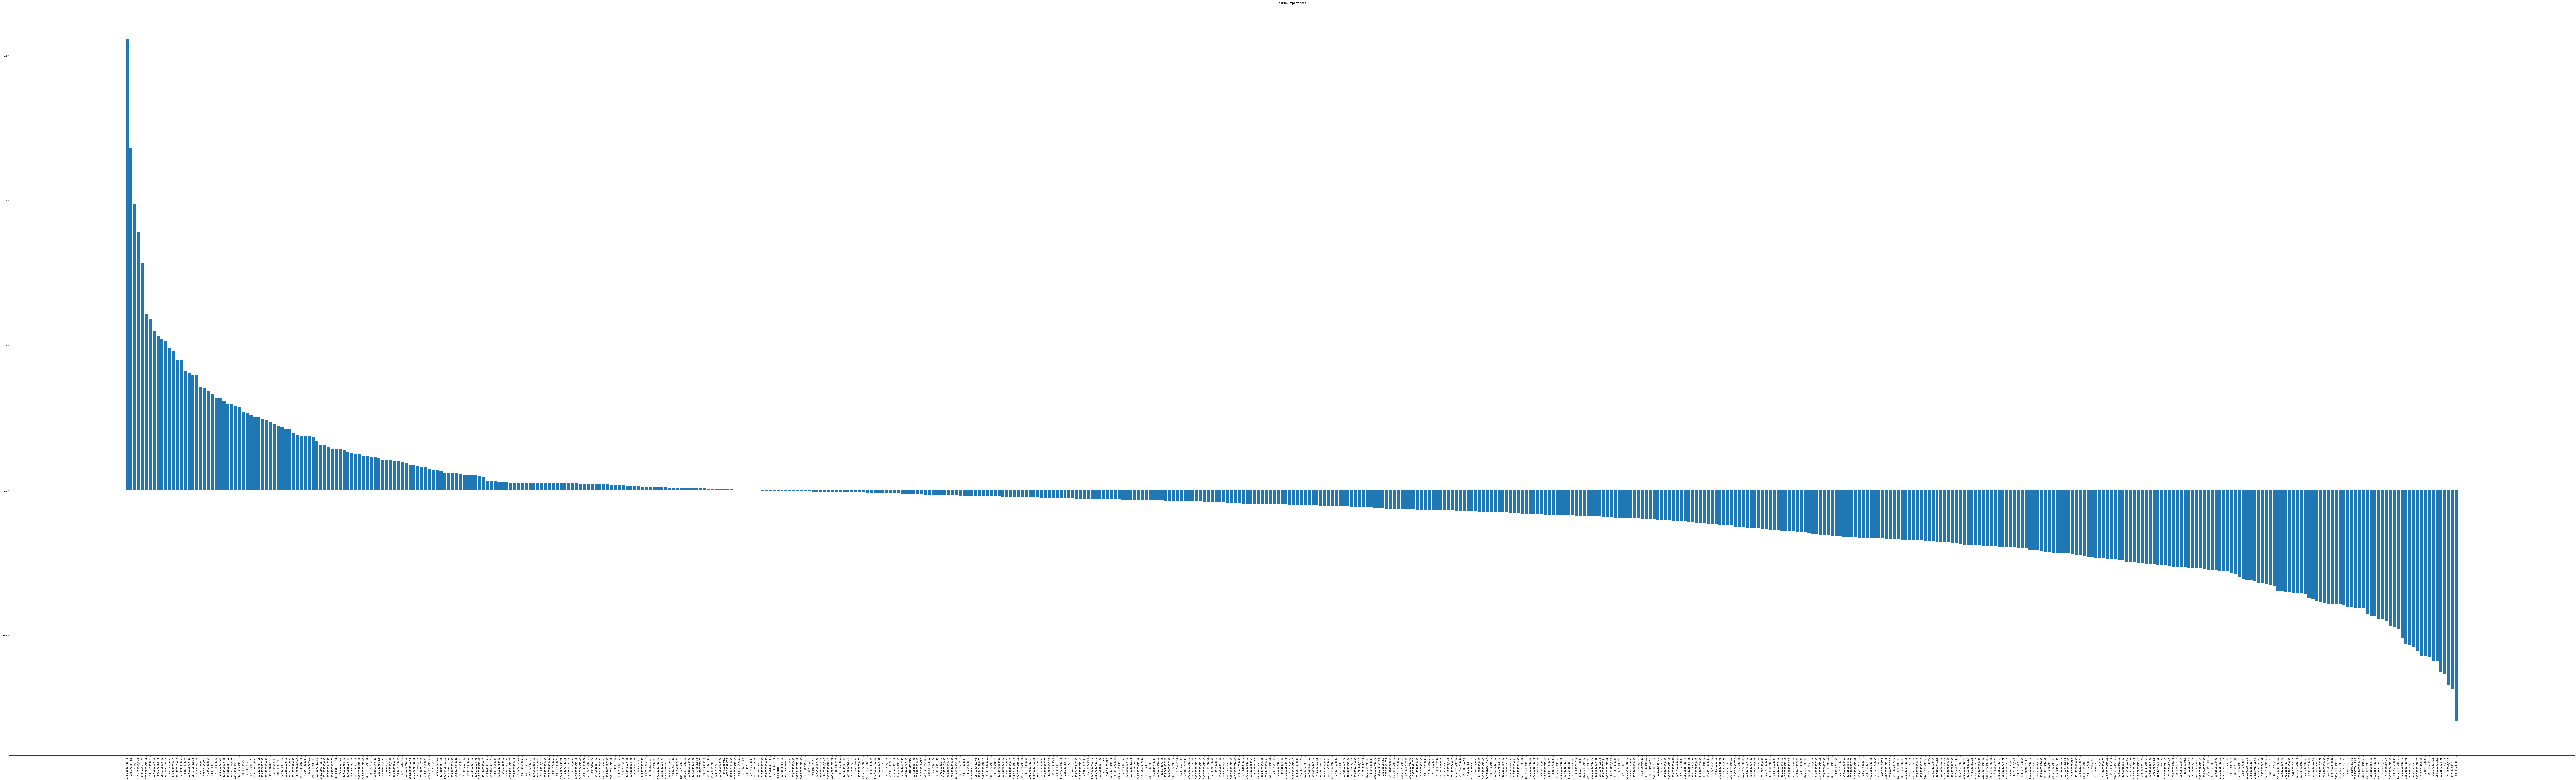

In [63]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_WWTP.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_WWTP.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [64]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_WWTP.xlsx', index=False)

In [65]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [66]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [67]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


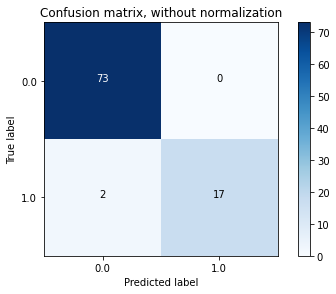

Normalized confusion matrix


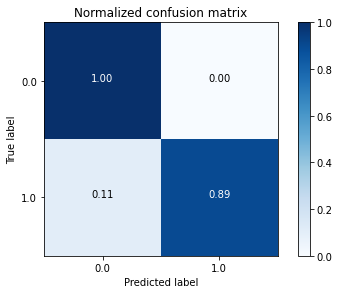

In [68]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### For PP

In [69]:
data_rf = pd.read_csv(r'240617-NTA-Noramlized-Filtered-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [70]:
#Prompt user for source type of interest (GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: PP


In [71]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [72]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [73]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Logistic Regression
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
C_val = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solver,penalty=penalty,C=C_val)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = LogisticRegression()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 1.000000 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.985000 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 1.000000 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.993333 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.991667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 1.000000 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 1.000000 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.993333 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 1.000000 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best: 0.991667 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

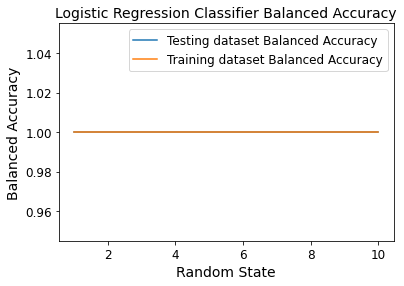

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 1


In [74]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Logistic Regression Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('lR-Tuning-NORM-PP.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [75]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Feature: 0, Score: -0.09033
Feature: 1, Score: 0.00000
Feature: 2, Score: -0.09910
Feature: 3, Score: -0.76714
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00302
Feature: 9, Score: -0.03241
Feature: 10, Score: -0.03967
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: -0.10495
Feature: 14, Score: -0.06280
Feature: 15, Score: 0.00000
Feature: 16, Score: -0.03477
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: -0.04168
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: -0.23621
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: -0.13221
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: -0.27014
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score

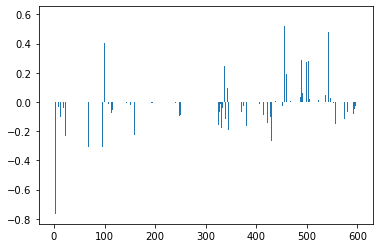

In [76]:
#Now running optimized model over the entire dataset
model = LogisticRegression(solver = 'liblinear', C = 100, penalty = 'l1')
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: -0.13694, Standard Deviation: 0.05388
Feature 1: Average Score: -0.00065, Standard Deviation: 0.00296
Feature 2: Average Score: -0.13993, Standard Deviation: 0.04996
Feature 3: Average Score: -0.23895, Standard Deviation: 0.05995
Feature 4: Average Score: -0.02190, Standard Deviation: 0.03156
Feature 5: Average Score: -0.00569, Standard Deviation: 0.01093
Feature 6: Average Score: -0.00304, Standard Deviation: 0.02137
Feature 7: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 8: Average Score: 0.00473, Standard Deviation: 0.01317
Feature 9: Average Score: -0.03599, Standard Deviation: 0.04191
Feature 10: Average Score: -0.13351, Standard Deviation: 0.05794
Feature 11: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 12: Average Score: -0.00729, Standard Deviation: 0.01578
Feature 13: Average Score: -0.19591, Standard Deviation: 0.06353
Feature 14: Average Score: -0.03321, Standard Deviation: 0.05908
Feature 15: Average Score: -0.00058, S

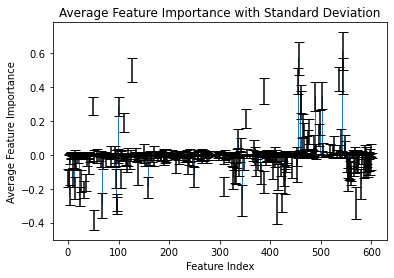

In [77]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = LogisticRegression(solver = 'liblinear', C = 100, penalty = 'l1')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.coef_[0]
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [78]:
labels_dat = pd.read_csv("240617-NTA-Noramlized-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 389.104431/8.13, Mean Score: 0.60983, Standard Deviation: 0.11231
Feature: 417.227422/10.68, Mean Score: 0.56815, Standard Deviation: 0.09701
Feature: 171.138736/11.07, Mean Score: 0.49972, Standard Deviation: 0.06815
Feature: 345.147181/10.66, Mean Score: 0.46382, Standard Deviation: 0.10583
Feature: 997.578678/21.38, Mean Score: 0.44510, Standard Deviation: 0.07057
Feature: 363.180801/8.03, Mean Score: 0.43581, Standard Deviation: 0.07601
Feature: 556.391351/16.76, Mean Score: 0.37535, Standard Deviation: 0.07466
Feature: 118.041154/6.64, Mean Score: 0.34848, Standard Deviation: 0.07919
Feature: 251.200899/15.84, Mean Score: 0.34397, Standard Deviation: 0.08487
Feature: 367.284744/18.13, Mean Score: 0.32908, Standard Deviation: 0.08349


In [79]:
labels_dat = pd.read_csv("240617-NTA-Noramlized-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 389.104431/8.13, Mean Score: 0.60983, Standard Deviation: 0.11231
Feature: 417.227422/10.68, Mean Score: 0.56815, Standard Deviation: 0.09701
Feature: 171.138736/11.07, Mean Score: 0.49972, Standard Deviation: 0.06815
Feature: 345.147181/10.66, Mean Score: 0.46382, Standard Deviation: 0.10583
Feature: 997.578678/21.38, Mean Score: 0.44510, Standard Deviation: 0.07057
Feature: 363.180801/8.03, Mean Score: 0.43581, Standard Deviation: 0.07601
Feature: 556.391351/16.76, Mean Score: 0.37535, Standard Deviation: 0.07466
Feature: 118.041154/6.64, Mean Score: 0.34848, Standard Deviation: 0.07919
Feature: 251.200899/15.84, Mean Score: 0.34397, Standard Deviation: 0.08487
Feature: 367.284744/18.13, Mean Score: 0.32908, Standard Deviation: 0.08349


Top Features with Significant Importance:
1. Feature: 389.104431/8.13, Mean Score: 0.60983, Standard Deviation: 0.11231
2. Feature: 417.227422/10.68, Mean Score: 0.56815, Standard Deviation: 0.09701
3. Feature: 171.138736/11.07, Mean Score: 0.49972, Standard Deviation: 0.06815
4. Feature: 345.147181/10.66, Mean Score: 0.46382, Standard Deviation: 0.10583
5. Feature: 997.578678/21.38, Mean Score: 0.44510, Standard Deviation: 0.07057
6. Feature: 363.180801/8.03, Mean Score: 0.43581, Standard Deviation: 0.07601
7. Feature: 556.391351/16.76, Mean Score: 0.37535, Standard Deviation: 0.07466
8. Feature: 118.041154/6.64, Mean Score: 0.34848, Standard Deviation: 0.07919
9. Feature: 251.200899/15.84, Mean Score: 0.34397, Standard Deviation: 0.08487
10. Feature: 367.284744/18.13, Mean Score: 0.32908, Standard Deviation: 0.08349
11. Feature: 417.227588/11.44, Mean Score: 0.29262, Standard Deviation: 0.08289
12. Feature: 254.220132/16.9, Mean Score: 0.28635, Standard Deviation: 0.05412
13. Feature

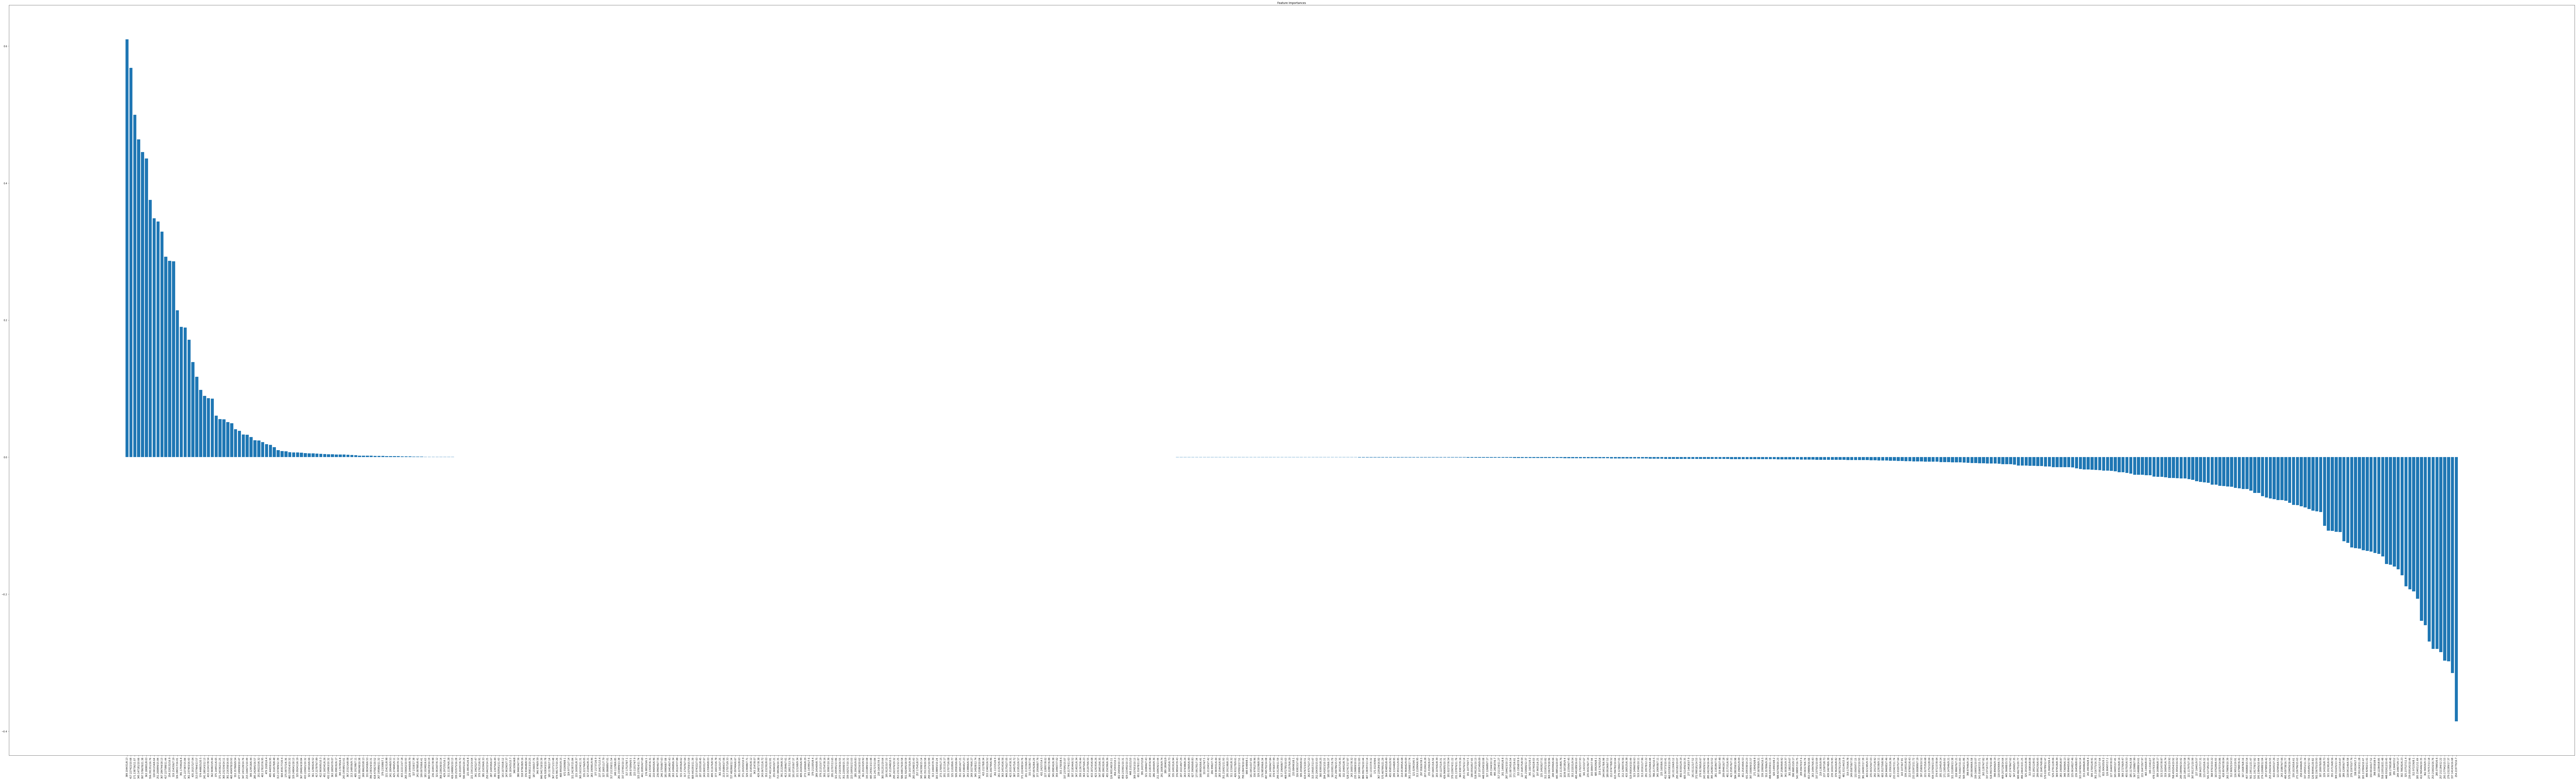

In [80]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_WWTP.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_PP.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [81]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_PP.xlsx', index=False)

In [82]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = LogisticRegression(solver = 'liblinear', C = 100, penalty = 'l1')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [83]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [84]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


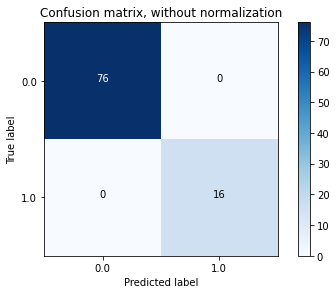

Normalized confusion matrix


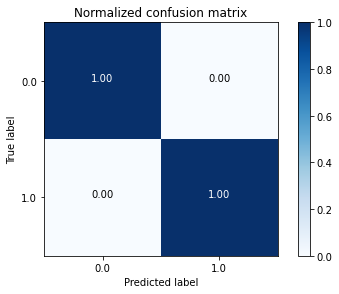

In [85]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### For PG

In [86]:
data_rf = pd.read_csv(r'240617-NTA-Noramlized-Filtered-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [87]:
#Prompt user for source type of interest (GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: PG


In [88]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [89]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [90]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Logistic Regression
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
C_val = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solver,penalty=penalty,C=C_val)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = LogisticRegression()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.883333 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.866667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.766667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.883333 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.916667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.866667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.916667 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.766667 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.900000 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best: 0.800000 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

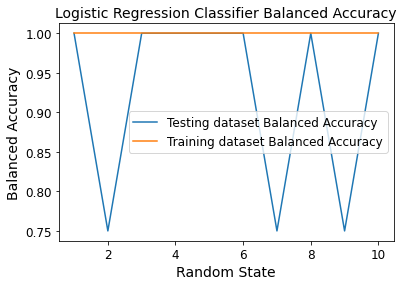

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 1


In [91]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Logistic Regression Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('lR-Tuning-NORM-PG.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [92]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.   0.75 1.   1.   1.   1.   0.75 1.   0.75 1.  ]


Feature: 0, Score: -0.03513
Feature: 1, Score: 0.02056
Feature: 2, Score: -0.09345
Feature: 3, Score: -0.15793
Feature: 4, Score: -0.06864
Feature: 5, Score: 0.05573
Feature: 6, Score: -0.05104
Feature: 7, Score: -0.11222
Feature: 8, Score: -0.03941
Feature: 9, Score: 0.01839
Feature: 10, Score: -0.05277
Feature: 11, Score: 0.09625
Feature: 12, Score: 0.04518
Feature: 13, Score: -0.15350
Feature: 14, Score: -0.04235
Feature: 15, Score: -0.03495
Feature: 16, Score: -0.07194
Feature: 17, Score: -0.03618
Feature: 18, Score: -0.02301
Feature: 19, Score: -0.04344
Feature: 20, Score: -0.02109
Feature: 21, Score: -0.10117
Feature: 22, Score: -0.01883
Feature: 23, Score: -0.04280
Feature: 24, Score: -0.10058
Feature: 25, Score: -0.16719
Feature: 26, Score: -0.08375
Feature: 27, Score: -0.02078
Feature: 28, Score: -0.07330
Feature: 29, Score: -0.01944
Feature: 30, Score: -0.02794
Feature: 31, Score: -0.01907
Feature: 32, Score: 0.09159
Feature: 33, Score: -0.03991
Feature: 34, Score: -0.18401
F

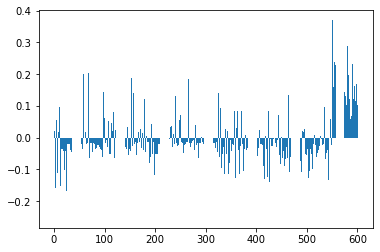

In [93]:
#Now running optimized model over the entire dataset
model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: -0.03513, Standard Deviation: 0.00000
Feature 1: Average Score: 0.02056, Standard Deviation: 0.00000
Feature 2: Average Score: -0.09345, Standard Deviation: 0.00000
Feature 3: Average Score: -0.15793, Standard Deviation: 0.00000
Feature 4: Average Score: -0.06864, Standard Deviation: 0.00000
Feature 5: Average Score: 0.05573, Standard Deviation: 0.00000
Feature 6: Average Score: -0.05104, Standard Deviation: 0.00000
Feature 7: Average Score: -0.11222, Standard Deviation: 0.00000
Feature 8: Average Score: -0.03941, Standard Deviation: 0.00000
Feature 9: Average Score: 0.01839, Standard Deviation: 0.00000
Feature 10: Average Score: -0.05277, Standard Deviation: 0.00000
Feature 11: Average Score: 0.09625, Standard Deviation: 0.00000
Feature 12: Average Score: 0.04518, Standard Deviation: 0.00000
Feature 13: Average Score: -0.15350, Standard Deviation: 0.00000
Feature 14: Average Score: -0.04235, Standard Deviation: 0.00000
Feature 15: Average Score: -0.03495, Sta

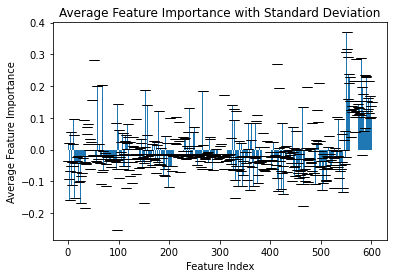

In [94]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.coef_[0]
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [95]:
labels_dat = pd.read_csv("240617-NTA-Noramlized-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 126.90512/19.91, Mean Score: 0.36958, Standard Deviation: 0.00000
Feature: 584.280358/19.98, Mean Score: 0.31592, Standard Deviation: 0.00000
Feature: 528.217417/17.87, Mean Score: 0.30587, Standard Deviation: 0.00000
Feature: 558.220518/21.48, Mean Score: 0.29236, Standard Deviation: 0.00000
Feature: 302.788282/6.23, Mean Score: 0.28849, Standard Deviation: 0.00000
Feature: 257.211184/12.22, Mean Score: 0.28475, Standard Deviation: 0.00000
Feature: 254.219779/16.7, Mean Score: 0.28359, Standard Deviation: 0.00000
Feature: 337.141436/16.68, Mean Score: 0.26933, Standard Deviation: 0.00000
Feature: 502.156755/19.93, Mean Score: 0.23832, Standard Deviation: 0.00000
Feature: 407.138397/13.14, Mean Score: 0.23355, Standard Deviation: 0.00000


In [96]:
labels_dat = pd.read_csv("240617-NTA-Noramlized-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 126.90512/19.91, Mean Score: 0.36958, Standard Deviation: 0.00000
Feature: 584.280358/19.98, Mean Score: 0.31592, Standard Deviation: 0.00000
Feature: 528.217417/17.87, Mean Score: 0.30587, Standard Deviation: 0.00000
Feature: 558.220518/21.48, Mean Score: 0.29236, Standard Deviation: 0.00000
Feature: 302.788282/6.23, Mean Score: 0.28849, Standard Deviation: 0.00000
Feature: 257.211184/12.22, Mean Score: 0.28475, Standard Deviation: 0.00000
Feature: 254.219779/16.7, Mean Score: 0.28359, Standard Deviation: 0.00000
Feature: 337.141436/16.68, Mean Score: 0.26933, Standard Deviation: 0.00000
Feature: 502.156755/19.93, Mean Score: 0.23832, Standard Deviation: 0.00000
Feature: 407.138397/13.14, Mean Score: 0.23355, Standard Deviation: 0.00000


Top Features with Significant Importance:
1. Feature: 126.90512/19.91, Mean Score: 0.36958, Standard Deviation: 0.00000
2. Feature: 584.280358/19.98, Mean Score: 0.31592, Standard Deviation: 0.00000
3. Feature: 528.217417/17.87, Mean Score: 0.30587, Standard Deviation: 0.00000
4. Feature: 558.220518/21.48, Mean Score: 0.29236, Standard Deviation: 0.00000
5. Feature: 302.788282/6.23, Mean Score: 0.28849, Standard Deviation: 0.00000
6. Feature: 257.211184/12.22, Mean Score: 0.28475, Standard Deviation: 0.00000
7. Feature: 254.219779/16.7, Mean Score: 0.28359, Standard Deviation: 0.00000
8. Feature: 337.141436/16.68, Mean Score: 0.26933, Standard Deviation: 0.00000
9. Feature: 502.156755/19.93, Mean Score: 0.23832, Standard Deviation: 0.00000
10. Feature: 407.138397/13.14, Mean Score: 0.23355, Standard Deviation: 0.00000
11. Feature: 323.146888/14.61, Mean Score: 0.23168, Standard Deviation: 0.00000
12. Feature: 255.250634/16.55, Mean Score: 0.22975, Standard Deviation: 0.00000
13. Featur

104. Feature: 215.164729/7.97, Mean Score: 0.04632, Standard Deviation: 0.00000
105. Feature: 171.138549/9.93, Mean Score: 0.04518, Standard Deviation: 0.00000
106. Feature: 309.169866/8.17, Mean Score: 0.04428, Standard Deviation: 0.00000
107. Feature: 209.094616/7.18, Mean Score: 0.04313, Standard Deviation: 0.00000
108. Feature: 345.098342/6.38, Mean Score: 0.04116, Standard Deviation: 0.00000
109. Feature: 369.979528/8.39, Mean Score: 0.04067, Standard Deviation: 0.00000
110. Feature: 141.011121/7.52, Mean Score: 0.03974, Standard Deviation: 0.00000
111. Feature: 289.120856/7.98, Mean Score: 0.03946, Standard Deviation: 0.00000
112. Feature: 287.129338/9.11, Mean Score: 0.03942, Standard Deviation: 0.00000
113. Feature: 429.248717/8.38, Mean Score: 0.03804, Standard Deviation: 0.00000
114. Feature: 239.165027/6.95, Mean Score: 0.03798, Standard Deviation: 0.00000
115. Feature: 325.201421/8.06, Mean Score: 0.03716, Standard Deviation: 0.00000
116. Feature: 299.131448/8.95, Mean Scor

242. Feature: 153.09174/7.5, Mean Score: -0.01483, Standard Deviation: 0.00000
243. Feature: 231.01942/6.67, Mean Score: -0.01486, Standard Deviation: 0.00000
244. Feature: 387.144575/6.72, Mean Score: -0.01535, Standard Deviation: 0.00000
245. Feature: 379.229074/11.22, Mean Score: -0.01545, Standard Deviation: 0.00000
246. Feature: 477.261247/7.88, Mean Score: -0.01545, Standard Deviation: 0.00000
247. Feature: 281.118184/7.91, Mean Score: -0.01548, Standard Deviation: 0.00000
248. Feature: 441.269924/7.69, Mean Score: -0.01554, Standard Deviation: 0.00000
249. Feature: 495.441089/16.63, Mean Score: -0.01555, Standard Deviation: 0.00000
250. Feature: 499.311676/8.56, Mean Score: -0.01564, Standard Deviation: 0.00000
251. Feature: 193.122751/9.31, Mean Score: -0.01565, Standard Deviation: 0.00000
252. Feature: 227.164575/8.59, Mean Score: -0.01572, Standard Deviation: 0.00000
253. Feature: 210.946926/6.96, Mean Score: -0.01575, Standard Deviation: 0.00000
254. Feature: 206.9982/7.72, 

345. Feature: 335.221889/10.08, Mean Score: -0.02307, Standard Deviation: 0.00000
346. Feature: 799.138478/10.42, Mean Score: -0.02316, Standard Deviation: 0.00000
347. Feature: 338.091045/7.3, Mean Score: -0.02329, Standard Deviation: 0.00000
348. Feature: 227.128957/8.02, Mean Score: -0.02340, Standard Deviation: 0.00000
349. Feature: 648.93489/8.1, Mean Score: -0.02361, Standard Deviation: 0.00000
350. Feature: 369.000899/7.19, Mean Score: -0.02379, Standard Deviation: 0.00000
351. Feature: 455.156396/6.36, Mean Score: -0.02397, Standard Deviation: 0.00000
352. Feature: 547.470922/17.51, Mean Score: -0.02406, Standard Deviation: 0.00000
353. Feature: 118.029369/6.72, Mean Score: -0.02408, Standard Deviation: 0.00000
354. Feature: 381.244907/17.39, Mean Score: -0.02417, Standard Deviation: 0.00000
355. Feature: 233.118197/6.98, Mean Score: -0.02421, Standard Deviation: 0.00000
356. Feature: 325.092413/6.19, Mean Score: -0.02421, Standard Deviation: 0.00000
357. Feature: 201.022727/6.

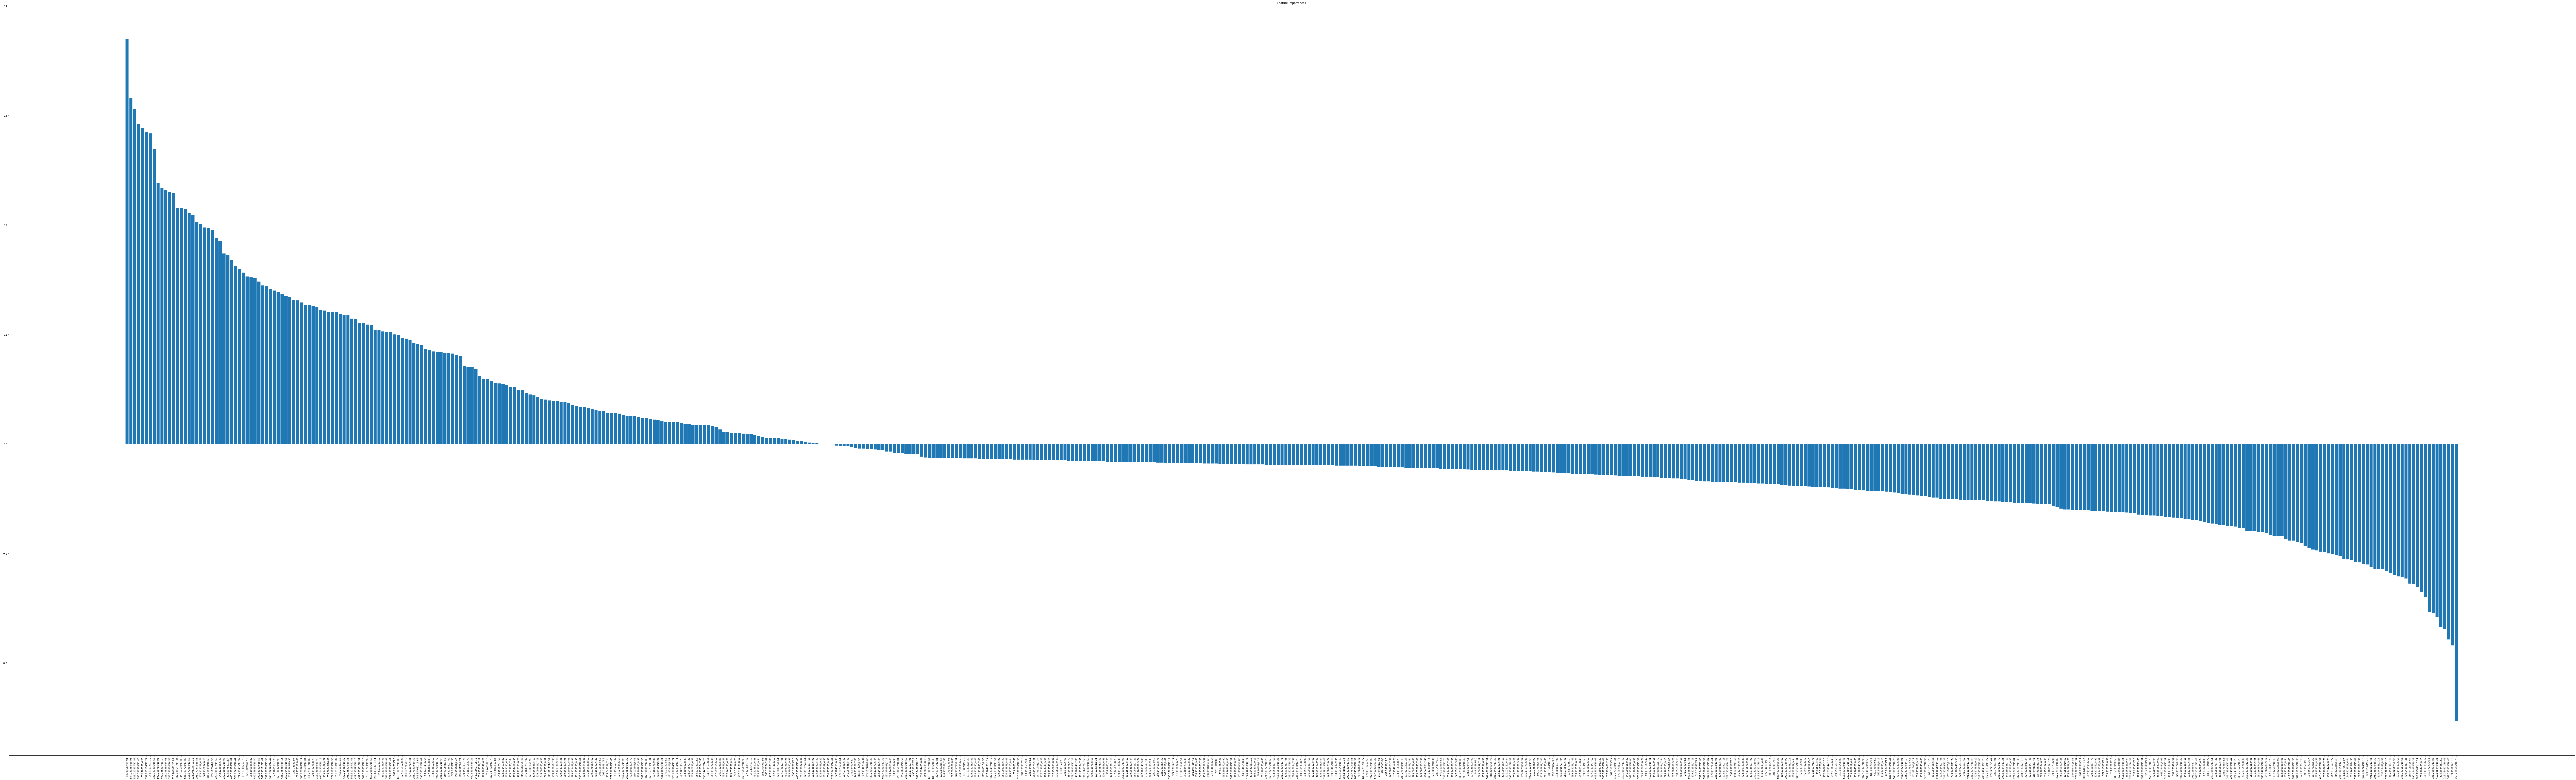

In [97]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_PG.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_PG.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [98]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_PG.xlsx', index=False)

In [99]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [100]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [101]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


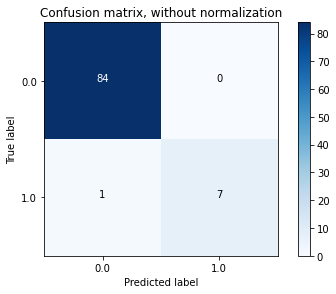

Normalized confusion matrix


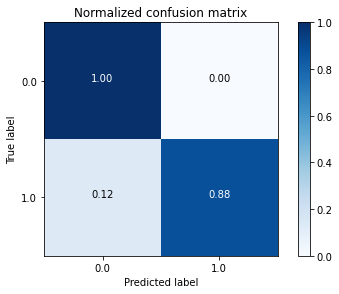

In [102]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)